## Building the Simplest Possible Autoencoder

Let's start simple with a single fully-connected neural layers as encoder and as decoder:

In [1]:
#importing our stuff
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a seperate encoder model:

In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

and a sepreate decoder model:

In [3]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now, let's train our autoencoder to reconstruct MNIST digits

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Next, prepare our input data. We're using MNIST digits, and discarding the labels, since we're only inetersted in encoding/decodiing the input images

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

Next, normalize all values between 0 and 1, and flatten the 28x28 images into vectors of size 784

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now, let's train our autoencoder for 50 epochs:

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 3s 9ms/step - loss: 0.2776 - val_loss: 0.1925
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1724 - val_loss: 0.1537
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1442 - val_loss: 0.1336
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1287 - val_loss: 0.1216
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1187 - val_loss: 0.1134
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1118 - val_loss: 0.1075
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1065 - val_loss: 0.1030
Epoch 8/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1025 - val_loss: 0.0995
Epoch 9/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0995 - val_loss: 0.0971
Epoch 10/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0975 - val_loss: 0.095

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

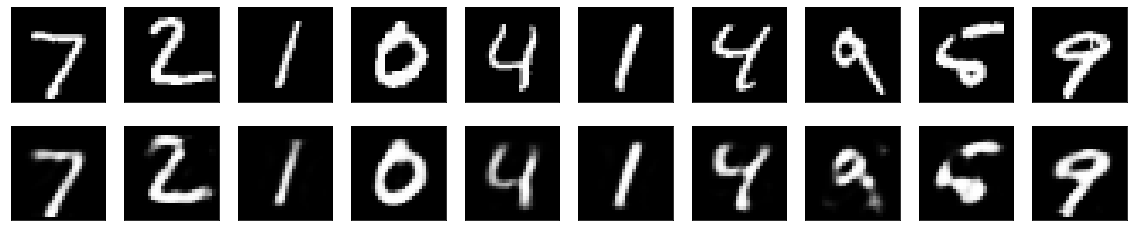

In [8]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

^Here's what we get: The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

## Adding Sparsity Constraint on Encoded Representations
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [9]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

## Deep Autoencoder
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [10]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [11]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 13ms/step - loss: 0.2472 - val_loss: 0.1701
Epoch 2/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1545 - val_loss: 0.1407
Epoch 3/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1359 - val_loss: 0.1293
Epoch 4/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1259 - val_loss: 0.1204
Epoch 5/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1185 - val_loss: 0.1141
Epoch 6/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1133 - val_loss: 0.1098
Epoch 7/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1097 - val_loss: 0.1071
Epoch 8/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1070 - val_loss: 0.1049
Epoch 9/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1047 - val_loss: 0.1025
Epoch 10/100
235/235 [==============================] - 3s 15ms/step - loss: 0.102

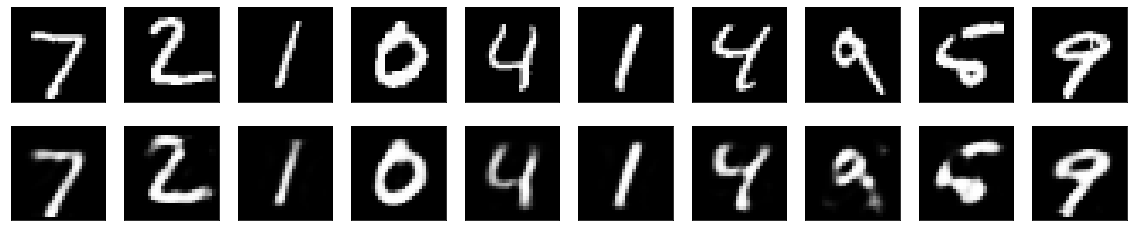

In [12]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

After 100 epochs, it reaches a train and validation loss of ~0.08, a bit better than our previous models. Our reconstructed digits look a bit better too!

## Convolutional Autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [13]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [14]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder. <---couldn't do??

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [15]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 69s 144ms/step - loss: 0.2101 - val_loss: 0.1441
Epoch 2/50
469/469 [==============================] - 63s 135ms/step - loss: 0.1334 - val_loss: 0.1245
Epoch 3/50
469/469 [==============================] - 83s 177ms/step - loss: 0.1219 - val_loss: 0.1178
Epoch 4/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1164 - val_loss: 0.1135
Epoch 5/50
469/469 [==============================] - 70s 150ms/step - loss: 0.1128 - val_loss: 0.1103
Epoch 6/50
469/469 [==============================] - 74s 159ms/step - loss: 0.1102 - val_loss: 0.1078
Epoch 7/50
469/469 [==============================] - 74s 159ms/step - loss: 0.1083 - val_loss: 0.1061
Epoch 8/50
469/469 [==============================] - 76s 162ms/step - loss: 0.1068 - val_loss: 0.1051
Epoch 9/50
469/469 [==============================] - 71s 151ms/step - loss: 0.1055 - val_loss: 0.1039
Epoch 10/50
469/469 [==============================] - 74s 157ms/step - l

This allows us to monitor training in the TensorBoard web interface. The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

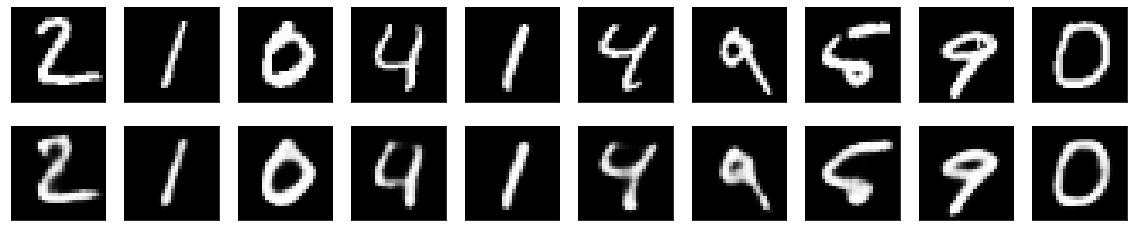

In [16]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

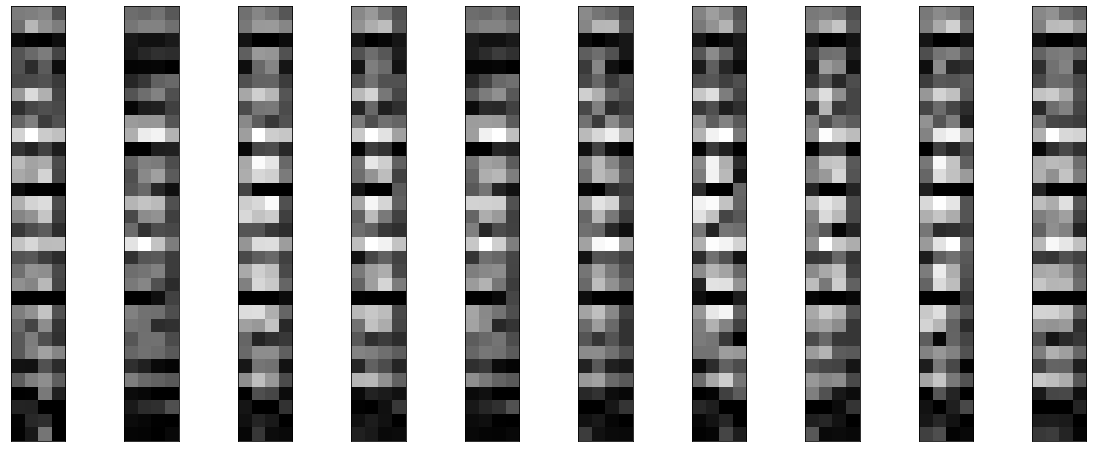

In [17]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Application to Image Denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [18]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

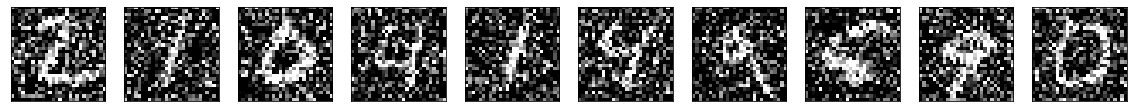

In [19]:
#Here's what the noisy digits look like:

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

^If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.


Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [20]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's train it for 100 epochs:

In [21]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,batch_size=128, shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 161s 341ms/step - loss: 0.1603 - val_loss: 0.1177
Epoch 2/100
469/469 [==============================] - 171s 366ms/step - loss: 0.1149 - val_loss: 0.1106
Epoch 3/100
469/469 [==============================] - 139s 296ms/step - loss: 0.1098 - val_loss: 0.1066
Epoch 4/100
469/469 [==============================] - 133s 284ms/step - loss: 0.1065 - val_loss: 0.1043
Epoch 5/100
469/469 [==============================] - 158s 338ms/step - loss: 0.1044 - val_loss: 0.1026
Epoch 6/100
469/469 [==============================] - 161s 343ms/step - loss: 0.1027 - val_loss: 0.1015
Epoch 7/100
469/469 [==============================] - 154s 330ms/step - loss: 0.1015 - val_loss: 0.1002
Epoch 8/100
469/469 [==============================] - 805s 2s/step - loss: 0.1006 - val_loss: 0.0999
Epoch 9/100
469/469 [==============================] - 127s 271ms/step - loss: 0.0999 - val_loss: 0.0990
Epoch 10/100
469/469 [==============================] - 11

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network. It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models. 

## Sequence-to-sequence Autoencoder
If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

In [18]:
# timesteps = ...  # Length of your sequences
# input_dim = ... 
# latent_dim = ...

# inputs = keras.Input(shape=(timesteps, input_dim))
# encoded = layers.LSTM(latent_dim)(inputs)

# decoded = layers.RepeatVector(timesteps)(encoded)
# decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

# sequence_autoencoder = keras.Model(inputs, decoded)
#encoder = keras.Model(inputs, encoded)

## Variational Autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [22]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [23]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Finally, we can map these sampled latent points back to reconstructed inputs:

In [24]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

What we've done so far allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [25]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

We train our VAE on MNIST digits:

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 187.9245 - val_loss: 170.0380
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 167.9134 - val_loss: 164.9643
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 163.2352 - val_loss: 161.1073
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 160.4073 - val_loss: 159.1901
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 158.7687 - val_loss: 158.1964
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 157.5637 - val_loss: 156.9312
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 156.5976 - val_loss: 156.1072
Epoch 8/50
1875/1875 [==============================] - 603s 322ms/step - loss: 155.8053 - val_loss: 155.7762
Epoch 9/50
1875/1875 [==============================] - 20s 11ms/step - loss: 155.1243 - val_loss: 154.9583 2s - loss: 155.
Epoch 10/50
1875/1875 [=

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [52]:
thing=np.array(x_test_encoded)
thing.shape

(3, 10000, 2)

In [65]:
print(len(thing[:,0]))

3


In [59]:
thing[:,0]

array([[ 0.44231483, -0.58668965],
       [-1.4723835 , -1.4849105 ],
       [ 0.37424603, -0.60961497]], dtype=float32)

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 20000.

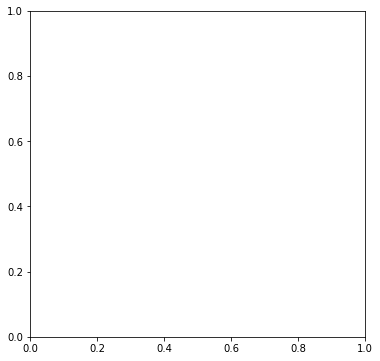

In [66]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(thing[0], thing[1], c=y_test)
plt.colorbar()
plt.show()

^^ Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space). <--- couldn't get to work?

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

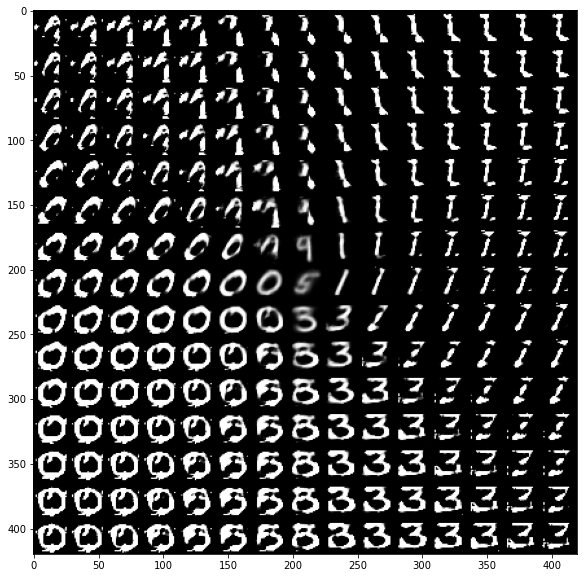

In [31]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

aaaand that's it! Make sure to refrence this tutorial when you need to build autoencoders in keras.